In [3]:
import pickle

import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.callbacks import LearningRateScheduler

In [4]:
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.regularizers import l2
from scipy.interpolate import splev, splrep
import pandas as pd
from sklearn.model_selection import train_test_split

In [5]:
base_dir = "dataset"

ir = 3 # interpolate interval
before = 2
after = 2

# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [6]:
from scipy.interpolate import CubicSpline
def interpolate_numpy_array(arr, desired_length):
    cs = CubicSpline(np.linspace(0, 1, len(arr)), arr)
    x_new = np.linspace(0, 1, desired_length)
    interpolated_arr = cs(x_new)
    return interpolated_arr

In [12]:
def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(base_dir, "T_1.pkl"), 'rb') as f: # read preprocessing result
        apnea_ecg = pickle.load(f)
    x,x_train,x_val = [],[],[]
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        min_distance_list, max_distance_list, mean_distance_list = o_train[i]
		# Curve interpolation
        min_distance_list_inter = interpolate_numpy_array(min_distance_list,900)
        max_distance_list_inter = interpolate_numpy_array(max_distance_list,900)
        mean_distance_list_inter = interpolate_numpy_array(mean_distance_list,900)
        x.append([min_distance_list_inter,max_distance_list_inter])
    groups_training,groups_val=[],[]

    num=[i for i in range(16707)]
    trainlist, vallist,y_train, y_val = train_test_split(num,y_train, test_size=0.3,random_state=42,stratify =y_train)
    print()
    for i in trainlist:
        x_train.append(x[i])
        groups_training.append(groups_train[i])
    for i in vallist:
        x_val.append(x[i])
        groups_val.append(groups_train[i])

    x_train = np.array(x_train, dtype="float32").transpose((0, 2, 1)) # convert to numpy format
    y_train= np.array(y_train, dtype="float32")
    x_val = np.array(x_val, dtype="float32").transpose((0, 2, 1)) # convert to numpy format
    y_val = np.array(y_val, dtype="float32")

    x_test = []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        min_distance_list, max_distance_list, mean_distance_list = o_test[i]
		# Curve interpolation
        min_distance_list_inter = interpolate_numpy_array(min_distance_list,900)
        max_distance_list_inter = interpolate_numpy_array(max_distance_list,900)
        mean_distance_list_inter = interpolate_numpy_array(mean_distance_list,900)
        x_test.append([min_distance_list_inter,max_distance_list_inter])
    x_test = np.array(x_test, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")

    return x_train,y_train, groups_training,x_val, y_val, groups_val, x_test, y_test, groups_test

In [8]:
#the original works
from keras.layers import BatchNormalization, LeakyReLU, GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.regularizers import l2

def create_model(input_shape, weight=1e-3):
    inputs = Input(shape=input_shape)
    leaky_relu = LeakyReLU()

    # Conv1
    x = Conv1D(64, kernel_size=5, strides=2, padding="valid", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(inputs)
    x = BatchNormalization()(x)
    x = leaky_relu(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.5)(x)  # Avoid overfitting
    # Conv2
    x = Conv1D(96, kernel_size=5, strides=2, padding="valid", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x)
    x = BatchNormalization()(x)
    x = leaky_relu(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Dropout(0.5)(x)  # Avoid overfitting

    # Conv3
    x = Conv1D(128, kernel_size=5, strides=2, padding="valid", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(x)
    x = BatchNormalization()(x)
    x = leaky_relu(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)  # Avoid overfitting

    # FC layers
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr

In [10]:
def plot(history):
    """Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], "r-", history["val_loss"], "b-", linewidth=0.5)
    axes[0].set_title("Loss")
    axes[1].plot(history["accuracy"], "r-", history["val_accuracy"], "b-", linewidth=0.5)
    axes[1].set_title("Accuracy")
    fig.tight_layout()
    plt.show()

In [13]:
from keras import optimizers
if __name__ == "__main__":

    x_train,y_train, groups_train,x_val, y_val, groups_val, x_test, y_test, groups_test= load_data()

    y_train = keras.utils.to_categorical(y_train, num_classes=2) # Convert to two categories
    y_val = keras.utils.to_categorical(y_val, num_classes=2)
    y_test = keras.utils.to_categorical(y_test, num_classes=2)

    print("train num:", len(y_train))
    print("test num:", len(y_test))


train num: 11694
test num: 16947


In [21]:
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, f1_score,roc_auc_score


model = create_model(input_shape=x_train.shape[1:])
model.summary()

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule) # Dynamic adjustment learning rate
history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_val, y_val),
                        callbacks=[lr_scheduler])

# evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Test loss: ", loss)
print("Accuracy: ", accuracy)

print("Testing:")
y_true, y_pred = y_test.argmax(axis=-1), np.argmax(model.predict(x_test, batch_size=1024, verbose=1), axis=-1)
y_true = to_categorical(y_true, num_classes=2)  # Convert y_true to binary label indicators
C = confusion_matrix(y_true[:, 1], y_pred, labels=(1, 0))  # Use y_true[:, 1] as binary label indicators for class 1
TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
precision = TP / (TP + FP)
recall = sn  # Recall is equivalent to sensitivity
f1 = 2 * (precision * recall) / (precision + recall)
print("TP:{}, TN:{}, FP:{}, FN:{}, loss{}, acc{}, sn{}, sp{}, f1{}".format(TP, TN, FP, FN,loss, acc, sn, sp, f1))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 900, 2)]     0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 448, 64)      704         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 448, 64)     256         ['conv1d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)      multiple             0           ['batch_normalization_9[0][

In [22]:
y_score = model.predict(x_test)
output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})
output.to_csv(os.path.join("output", "file_name.csv"), index=False)

530/530 [==============================] - 1s 2ms/step


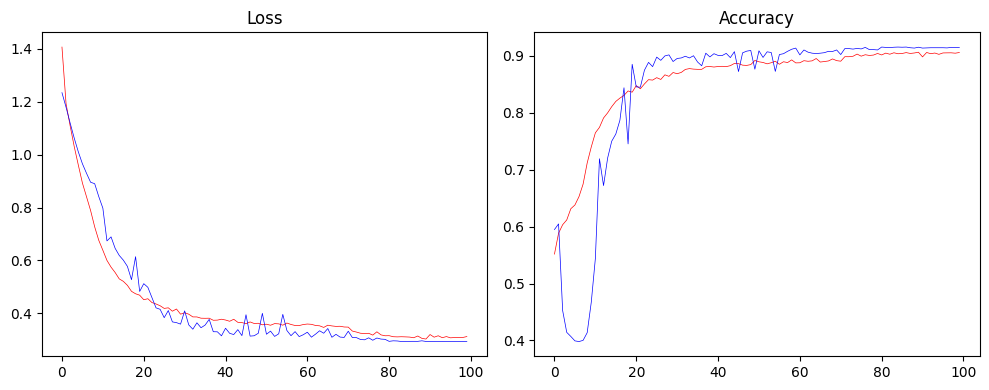

In [ ]:
plot(history.history)